In [1]:
from imports import *

In [2]:
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
import time

# Preprocessing
Load the dataset. IF is then run on samples of the dataset with different anomaly rates.

In [3]:
df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]

In [4]:
dfsf = df[df["logged_in"]== 1]
print(len(dfsf)- len(dfsf.loc[dfsf["target"]=='normal.']))
dfsf = dfsf[sf_columns + ["target"]] 
# print(dfsf.head(1))
# Split the dataset into 2 classes for consistent anomaly_rate when sampling
dfsf_normal = dfsf.loc[dfsf["target"]=='normal.']
dfsf_attack = dfsf.loc[dfsf["target"]!='normal.']
# print(f"A sample normal frame: \t {dfsf_normal.head(1)}")
# print("-----------------")
# print(f"A sample attack frame: \t {dfsf_attack.head(1)}")

3377


In [5]:
frac = 0.1

dfsf_frac = dfsf_normal.sample(frac = frac, random_state = 1).append(dfsf_attack.sample(frac = frac, random_state = 1))

anomaly_rate = 1.0 - len(dfsf_frac.loc[dfsf_frac["target"]=='normal.'])/len(dfsf_frac)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsf_frac)} records")

dfsf_frac['binary_target'] = [1 if x=='normal.' else -1 for x in dfsf_frac["target"]]
toDecode = toDecodeSF
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    dfsf_frac[f] = leSF.fit_transform(dfsf_frac[f])

dfsf_normed = preprocessing.normalize(dfsf_frac.drop(["target", "binary_target"], axis=1))

anomaly rate is 0.5% out of 70307 records


# Parameter tuning

In [6]:
def cross_validation_dbscan(eps, ms, silent=True):
    highest_score = 0
    best_eps = 0
    for e in eps:
        s = datetime.datetime.now()
        db = DBSCAN(eps=e, min_samples=ms, metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_train)
        y_pred = [1 if i != -1 else i for i in db.labels_]
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_train, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_train, y_pred)
        if f > highest_score: highest_score = f; best_eps = e
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        print(tp)
        # fp through formula
        fp = tp / p - tp
        
        # predicted true
        positives = yp[np.where(yp == -1)]
        if not silent:
            print(f"Finished trainning in {t} seconds")
            print(f"eps: {e} \t tp: {tp}/support: {s}/predicted: {len(positives)} -> fp = {len(positives) - tp}")
            print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
            print("--------------------")
    return (best_eps, y_pred, f, len(positives) - tp, tp, p, r, t)

In [7]:
Y_axis_f1 = []
Y_axis_recall = []
best_param = []

In [8]:
rs = 1
x_train, x_test, y_train, y_test = train_test_split(dfsf_normed, dfsf_frac['binary_target'], test_size=0.25, random_state=rs)
stime = time.time()
emax, y_pred, f, fp, tp, p, r, t = cross_validation_dbscan(np.arange(0.001, 0.01, 0.001), 10, silent=False)
print("Time for DBSCAN fitting: %.3f" % (time.time() - stime))
Y_axis_f1.append(f)
Y_axis_recall.append(r)
best_param.append(emax)

13
Finished trainning in 0:00:00.922131 seconds
eps: 0.001 	 tp: 13/support: 241/predicted: 7297 -> fp = 7284
AUC : 51.6% 	 precision: 0.00562 	 recall: 0.17 	 f1: 0.010878217033695941
--------------------
3
Finished trainning in 0:00:01.116792 seconds
eps: 0.002 	 tp: 3/support: 241/predicted: 2155 -> fp = 2152
AUC : 55.9% 	 precision: 0.0176 	 recall: 0.158 	 f1: 0.03171953255425709
--------------------
2
Finished trainning in 0:00:01.047303 seconds
eps: 0.003 	 tp: 2/support: 241/predicted: 1228 -> fp = 1226
AUC : 56.8% 	 precision: 0.0309 	 recall: 0.158 	 f1: 0.0517358747447243
--------------------
2
Finished trainning in 0:00:01.298054 seconds
eps: 0.004 	 tp: 2/support: 241/predicted: 844 -> fp = 842
AUC : 54.4% 	 precision: 0.0296 	 recall: 0.104 	 f1: 0.046082949308755755
--------------------
2
Finished trainning in 0:00:01.536055 seconds
eps: 0.005 	 tp: 2/support: 241/predicted: 708 -> fp = 706
AUC : 53.5% 	 precision: 0.0282 	 recall: 0.083 	 f1: 0.04214963119072708
-------

In [9]:
rs = 2
x_train, x_test, y_train, y_test = train_test_split(dfsf_normed, dfsf_frac['binary_target'], test_size=0.25, random_state=rs)
stime = time.time()
emax, y_pred, f, fp, tp, p, r, t = cross_validation_dbscan(np.arange(0.001, 0.01, 0.001), 15, silent=False)
print("Time for DBSCAN fitting: %.3f" % (time.time() - stime))
Y_axis_f1.append(f)
Y_axis_recall.append(r)
best_param.append(emax)

18
Finished trainning in 0:00:00.874414 seconds
eps: 0.001 	 tp: 18/support: 252/predicted: 11117 -> fp = 11099
AUC : 49.4% 	 precision: 0.0045 	 recall: 0.198 	 f1: 0.00879584835957428
--------------------
7
Finished trainning in 0:00:00.919391 seconds
eps: 0.002 	 tp: 7/support: 252/predicted: 2667 -> fp = 2660
AUC : 57.0% 	 precision: 0.018 	 recall: 0.19 	 f1: 0.0328879753340185
--------------------
4
Finished trainning in 0:00:01.216421 seconds
eps: 0.003 	 tp: 4/support: 252/predicted: 1480 -> fp = 1476
AUC : 58.0% 	 precision: 0.0318 	 recall: 0.187 	 f1: 0.054272517321016164
--------------------
2
Finished trainning in 0:00:01.390783 seconds
eps: 0.004 	 tp: 2/support: 252/predicted: 1039 -> fp = 1037
AUC : 58.2% 	 precision: 0.0443 	 recall: 0.183 	 f1: 0.07126258714175057
--------------------
1
Finished trainning in 0:00:01.500423 seconds
eps: 0.005 	 tp: 1/support: 252/predicted: 808 -> fp = 807
AUC : 57.8% 	 precision: 0.0532 	 recall: 0.171 	 f1: 0.08113207547169811
------

In [10]:
rs = 2
x_train, x_test, y_train, y_test = train_test_split(dfsf_normed, dfsf_frac['binary_target'], test_size=0.25, random_state=rs)
stime = time.time()
emax, y_pred, f, fp, tp, p, r, t = cross_validation_dbscan(np.arange(0.001, 0.01, 0.001), 20, silent=False)
print("Time for DBSCAN fitting: %.3f" % (time.time() - stime))
Y_axis_f1.append(f)
Y_axis_recall.append(r)
best_param.append(emax)

27
Finished trainning in 0:00:00.909267 seconds
eps: 0.001 	 tp: 27/support: 252/predicted: 14759 -> fp = 14732
AUC : 45.9% 	 precision: 0.00339 	 recall: 0.198 	 f1: 0.006661781360335754
--------------------
7
Finished trainning in 0:00:01.060602 seconds
eps: 0.002 	 tp: 7/support: 252/predicted: 3370 -> fp = 3363
AUC : 56.4% 	 precision: 0.0142 	 recall: 0.19 	 f1: 0.02650469353948095
--------------------
4
Finished trainning in 0:00:01.252720 seconds
eps: 0.003 	 tp: 4/support: 252/predicted: 1910 -> fp = 1906
AUC : 57.7% 	 precision: 0.0251 	 recall: 0.19 	 f1: 0.04440333024976874
--------------------
3
Finished trainning in 0:00:01.382927 seconds
eps: 0.004 	 tp: 3/support: 252/predicted: 1260 -> fp = 1257
AUC : 58.2% 	 precision: 0.0373 	 recall: 0.187 	 f1: 0.062169312169312166
--------------------
1
Finished trainning in 0:00:01.440342 seconds
eps: 0.005 	 tp: 1/support: 252/predicted: 1013 -> fp = 1012
AUC : 57.8% 	 precision: 0.0434 	 recall: 0.175 	 f1: 0.06956521739130435
-

In [11]:
rs = 4
x_train, x_test, y_train, y_test = train_test_split(dfsf_normed, dfsf_frac['binary_target'], test_size=0.25, random_state=rs)
stime = time.time()
emax, y_pred, f, fp, tp, p, r, t = cross_validation_dbscan(np.arange(0.001, 0.01, 0.001), 50, silent=False)
print("Time for DBSCAN fitting: %.3f" % (time.time() - stime))
Y_axis_f1.append(f)
Y_axis_recall.append(r)
best_param.append(emax)

27
Finished trainning in 0:00:00.941448 seconds
eps: 0.001 	 tp: 27/support: 273/predicted: 23505 -> fp = 23478
AUC : 36.2% 	 precision: 0.002 	 recall: 0.172 	 f1: 0.003953234081924468
--------------------
18
Finished trainning in 0:00:01.088777 seconds
eps: 0.002 	 tp: 18/support: 273/predicted: 12323 -> fp = 12305
AUC : 46.2% 	 precision: 0.00349 	 recall: 0.158 	 f1: 0.00682756430612893
--------------------
7
Finished trainning in 0:00:01.304566 seconds
eps: 0.003 	 tp: 7/support: 273/predicted: 3683 -> fp = 3676
AUC : 54.4% 	 precision: 0.0117 	 recall: 0.158 	 f1: 0.021739130434782605
--------------------
6
Finished trainning in 0:00:01.344049 seconds
eps: 0.004 	 tp: 6/support: 273/predicted: 2490 -> fp = 2484
AUC : 55.4% 	 precision: 0.0169 	 recall: 0.154 	 f1: 0.03040173724212812
--------------------
6
Finished trainning in 0:00:01.587433 seconds
eps: 0.005 	 tp: 6/support: 273/predicted: 1856 -> fp = 1850
AUC : 55.8% 	 precision: 0.0221 	 recall: 0.15 	 f1: 0.038515735086895

<ipython-input-12-8ab98b1eab00>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


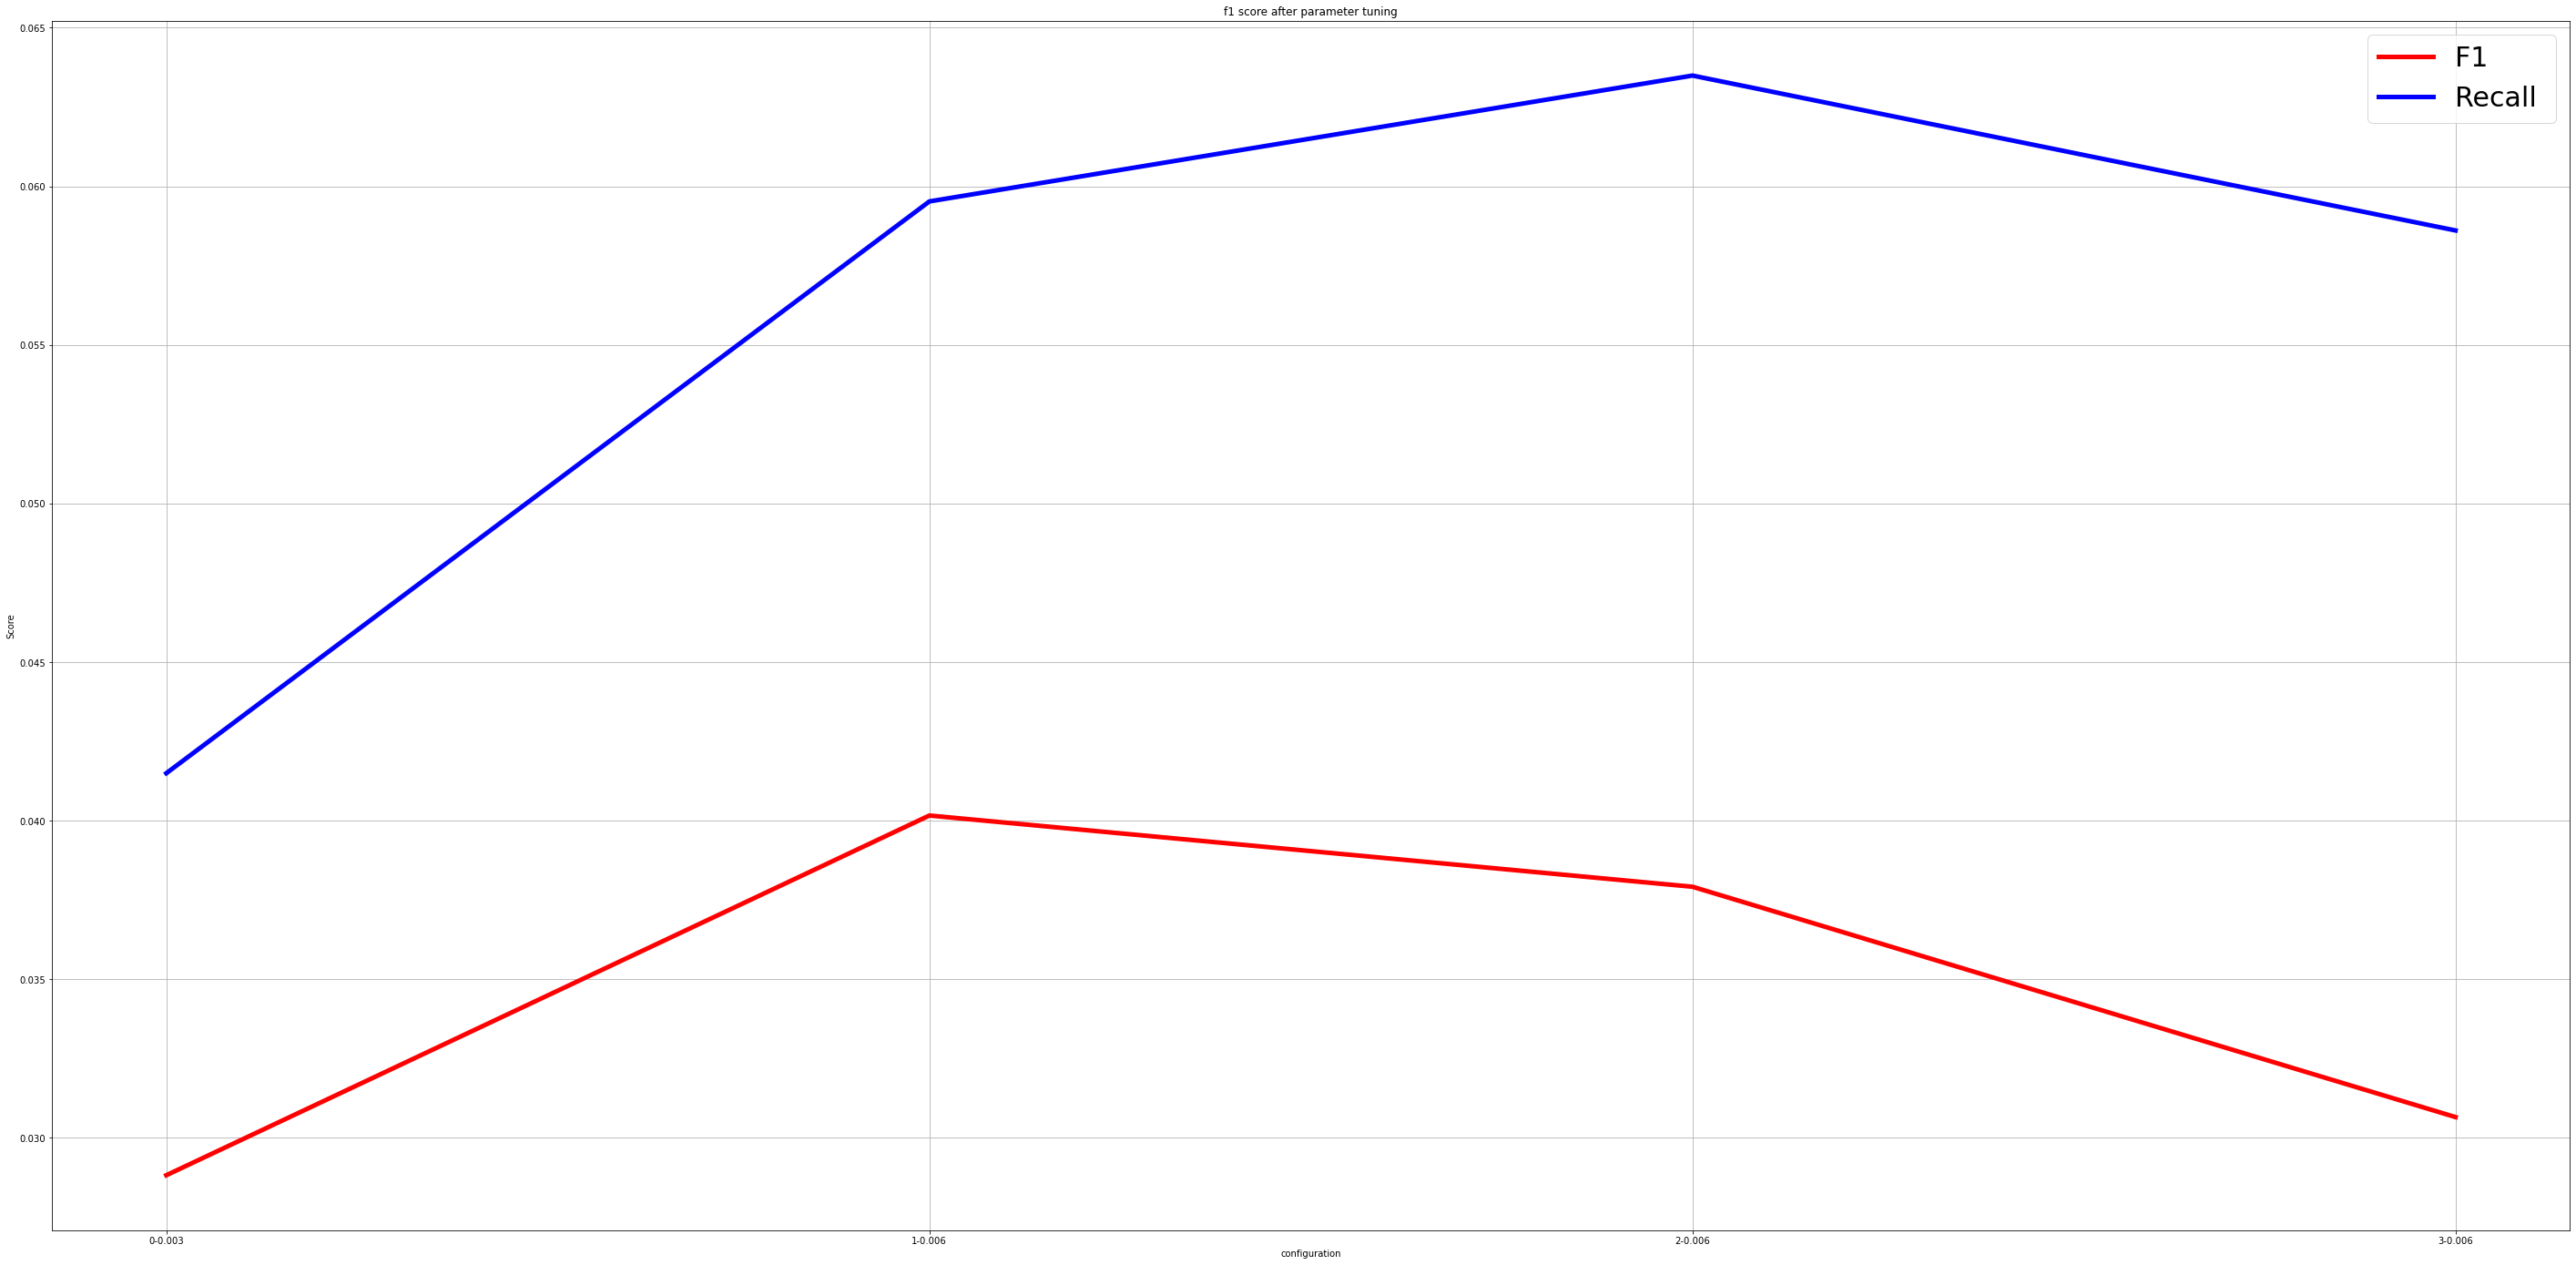

In [12]:
plt.figure(figsize=(40,20))
plt.title('f1 score after parameter tuning')
plt.xlabel("configuration")
plt.ylabel("Score")
plt.rc('font', size=30)
ax = plt.axes()
# ax.set_ylim(0.99, 0.992)
pad = 0.005

labels = [f"{i}-{p}" for i,p in enumerate(best_param)]
colors = {'1': 'r', '2':'b', '3':'c', '4':'y'}
scorer = 'F1'


# Y_axis = np.array([best_score_1, best_score_2, best_score_3, best_score_4])
# 
X_axis = np.array(labels)

ax.plot(X_axis, Y_axis_f1, '-', color=colors['1'],label="%s " % ("F1"), linewidth=5)
ax.plot(X_axis, Y_axis_recall, '-', color=colors['2'],label="%s " % ("Recall"), linewidth=5)
plt.legend(loc="best")
plt.grid('off')
plt.tight_layout()
plt.savefig("DBSCAN_graph_v2.png", dpi=100)

plt.show()

# Comparing against default value

In [33]:
f1_tuned = []
auc_tuned = []
r_tuned = []
f1_not_tuned = []
auc_not_tuned = []

In [34]:
rs = 1
x_train, x_test, y_train, y_test = train_test_split(dfsf_normed, dfsf_frac['binary_target'], test_size=0.25, random_state=rs)

e = best_param[0]
ms = 10
print(e)

stime = time.time()
db = DBSCAN(eps=e, min_samples=ms, metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
y_pred = [1 if i != -1 else i for i in db.labels_]
print("Time for IF fitting: %.3f" % (time.time() - stime))
f = f1_score(y_test, y_pred)
print(f"---{f}")
f1_tuned.append(f)
a = roc_auc_score(y_test, y_pred)
print(f"---{a}")
auc_tuned.append(a)
r = recall_score(y_test, y_pred)
print(f"---{r}")
r_tuned.append(r)
db = DBSCAN(metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
y_pred = [1 if i != -1 else i for i in db.labels_]
a = roc_auc_score(y_test, y_pred)
print(f"---{a}")
auc_not_tuned.append(a)

0.003
Time for IF fitting: 0.287
---0.9745955732056298
---0.5752836820873339
---0.9546910755148741
---0.5


In [35]:
rs = 2
x_train, x_test, y_train, y_test = train_test_split(dfsf_normed, dfsf_frac['binary_target'], test_size=0.25, random_state=rs)

e = best_param[1]
ms = 15

stime = time.time()
db = DBSCAN(eps=e, min_samples=ms, metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
y_pred = [1 if i != -1 else i for i in db.labels_]
print("Time for IF fitting: %.3f" % (time.time() - stime))
f = f1_score(y_test, y_pred)
print(f"---{f}")
f1_tuned.append(f)
a = roc_auc_score(y_test, y_pred)
print(f"---{a}")
auc_tuned.append(a)
r = recall_score(y_test, y_pred)
print(f"---{r}")
r_tuned.append(r)
db = DBSCAN(metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
y_pred = [1 if i != -1 else i for i in db.labels_]
a = roc_auc_score(y_test, y_pred)
print(f"---{a}")
auc_not_tuned.append(a)

Time for IF fitting: 0.298
---0.9862982086710705
---0.5235921995763935
---0.9774169572923218
---0.5


In [36]:
rs = 3
x_train, x_test, y_train, y_test = train_test_split(dfsf_normed, dfsf_frac['binary_target'], test_size=0.25, random_state=rs)

e = best_param[2]
ms = 20

stime = time.time()
db = DBSCAN(eps=e, min_samples=ms, metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
y_pred = [1 if i != -1 else i for i in db.labels_]
print("Time for IF fitting: %.3f" % (time.time() - stime))
f = f1_score(y_test, y_pred)
print(f"---{f}")
f1_tuned.append(f)
a = roc_auc_score(y_test, y_pred)
print(f"---{a}")
auc_tuned.append(a)
r = recall_score(y_test, y_pred)
print(f"---{r}")
r_tuned.append(r)
db = DBSCAN(metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
y_pred = [1 if i != -1 else i for i in db.labels_]
a = roc_auc_score(y_test, y_pred)
print(f"---{a}")
auc_not_tuned.append(a)

Time for IF fitting: 0.293
---0.9840856481481483
---0.6170039444349168
---0.9721031269650717
---0.5


In [37]:
rs = 4
x_train, x_test, y_train, y_test = train_test_split(dfsf_normed, dfsf_frac['binary_target'], test_size=0.25, random_state=rs)

e = best_param[3]
ms = 50

stime = time.time()
db = DBSCAN(eps=e, min_samples=ms, metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
y_pred = [1 if i != -1 else i for i in db.labels_]
print("Time for IF fitting: %.3f" % (time.time() - stime))
f = f1_score(y_test, y_pred)
print(f"---{f}")
f1_tuned.append(f)
a = roc_auc_score(y_test, y_pred)
print(f"---{a}")
auc_tuned.append(a)
r = recall_score(y_test, y_pred)
print(f"---{r}")
r_tuned.append(r)
db = DBSCAN(metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
y_pred = [1 if i != -1 else i for i in db.labels_]
a = roc_auc_score(y_test, y_pred)
print(f"---{a}")
auc_not_tuned.append(a)

Time for IF fitting: 0.366
---0.9590826938461082
---0.5467270794532101
---0.924223389675651
---0.5076923076923077


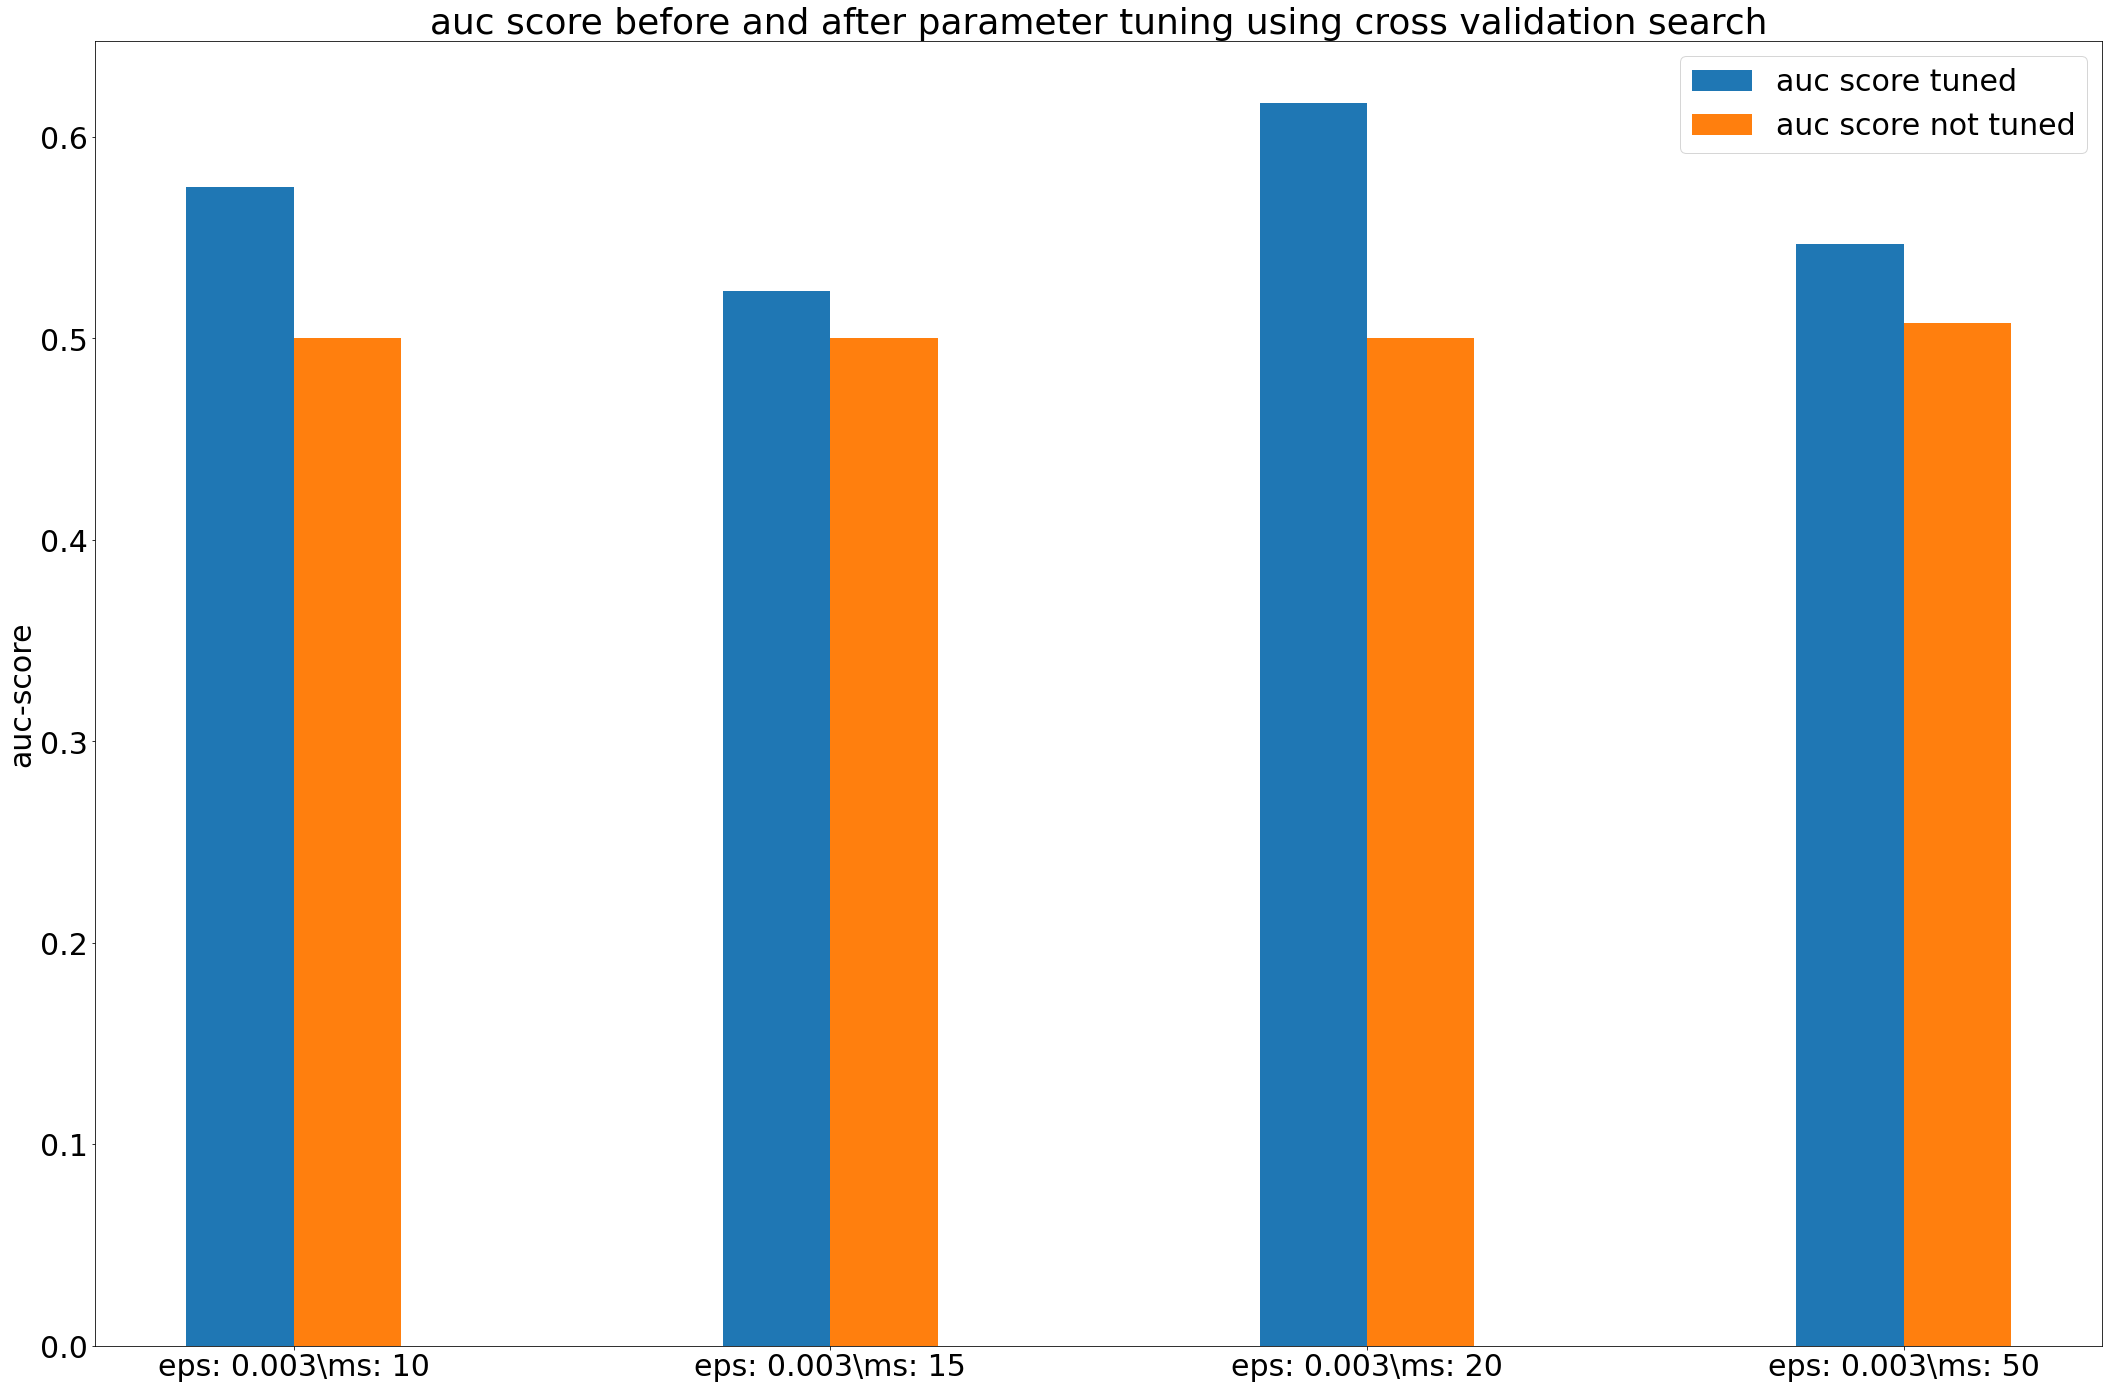

In [29]:
fig, ax = plt.subplots(figsize = (30,20))
plt.rc('font', size=30)

f1_tuned = [0.9954178136425095, 0.9952542140292294, 0.9953171367636211, 0.9952334249285871]
f1_default = [0.9615918309257809, 0.955213461022107, 0.9576507857113085, 0.9571646010002174]
width = 1
labels = [f"eps: {best_param[0]}\ms: {10}", 
          f"eps: {best_param[0]}\ms: {15}", 
          f"eps: {best_param[0]}\ms: {20}", 
          f"eps: {best_param[0]}\ms: {50}"]
ax.set_xticks([i*5 + width/2 for i in range(len(f1_tuned))])
ax.set_xticklabels(labels)
ax.set_ylabel('auc-score')

ax.set_title('auc score before and after parameter tuning using cross validation search')

ax.bar([i*5 for i in range(len(auc_tuned))], auc_tuned, width=width)
ax.bar([i*5 + width for i in range(len(auc_not_tuned))], auc_not_tuned, width=width)
fig.tight_layout()
ax.legend(['auc score tuned', 'auc score not tuned'])
plt.show()

# Means and standard deviation

In [39]:
import statistics 
m = statistics.mean(auc_tuned)
s = statistics.stdev(auc_tuned)
print(f"auc:\t {m} \pm {s}")
m = statistics.mean(f1_tuned)
s = statistics.stdev(f1_tuned)
print(f"f1:\t {m} \pm {s}")
m = statistics.mean(r_tuned)
s = statistics.stdev(r_tuned)
print(f"recall:\t {m} \pm {s}")

auc:	 0.5656517263879636 \pm 0.04023667864919072
f1:	 0.9760155309677392 \pm 0.012377365162397305
recall:	 0.9571086373619797 \pm 0.023976006739558988
